In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

def get_file(path):
    with open(path, "rb") as file:
        data = pickle.load(file)
    return data

def get_data(name):
    preds = []
    trues = []
    counts = []

    for fold in range(5):
        for value in get_file(f"./folds/{name}_fold_{fold}.pkl"):
            preds.append(value[0])
            trues.append(value[1])
            counts.append(value[2])

    preds = np.concatenate(preds, axis = 0)
    trues = np.concatenate(trues, axis = 0)
    counts = np.concatenate(counts, axis = 0)
    return preds, trues, counts

multi_preds, multi_trues, multi_counts = get_data("multi")
eeg_preds, eeg_trues, eeg_counts = get_data("eeg")
spec_preds, spec_trues, spec_counts = get_data("spec")

print(eeg_preds.shape)
print(spec_preds.shape)
print(multi_preds.shape)

(8545, 6)
(8545, 6)
(8545, 6)


In [2]:
preds, trues, counts = multi_preds, multi_trues, multi_counts

In [3]:
idealized_inds = trues.max(axis = 1) >= 0.8 # More than 80% agreement
hq_inds = counts >= 10 # High quality inds

print(np.mean(idealized_inds))
print(np.mean(hq_inds))
print(np.mean(idealized_inds & hq_inds))

0.6566413107080163
0.32896430661205384
0.13540081919251024


In [4]:
idealized_inds = (trues.max(axis = 1) >= 0.8) & (counts >= 3) # More than 80% agreement
hq_inds = counts >= 10 # High quality inds

print(np.mean(idealized_inds))
print(np.mean(hq_inds))
print(np.mean(idealized_inds & hq_inds))

0.4154476301930954
0.32896430661205384
0.13540081919251024


In [5]:
_, counts = np.unique(np.argmax(trues[idealized_inds], axis = 1), return_counts = True)
counts

array([1024,  478,  215,  124,  424, 1285])

[ 12. 265. 136.   7.  20. 717.]  |  1157
[1012.  213.   79.  117.  404.  568.]  |  2393


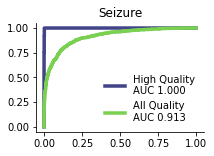

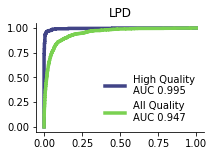

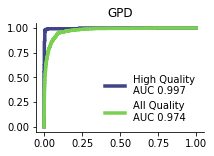

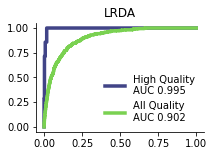

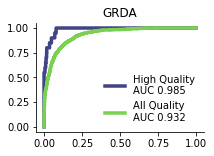

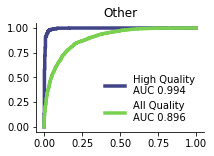


LQ:
0.9408 +- 0.0330

HQ:
0.9944 +- 0.0045

ALL:
0.9274 +- 0.0272


In [6]:
import sklearn
import sklearn.metrics
import seaborn as sns

inds = idealized_inds
lq_inds = ~hq_inds & idealized_inds
hq_inds = hq_inds & idealized_inds

def get_v(inds):
    plot_preds = preds.copy()[inds]
    plot_trues = trues.copy()[inds]
    temp = np.zeros_like(plot_trues)
    for i in range(len(plot_trues)):
        ind = np.argmax(plot_trues[i])
        temp[i, ind] = 1
    plot_trues = temp
    return plot_preds, plot_trues

hq_preds, hq_trues = get_v(hq_inds)
lq_preds, lq_trues = get_v(lq_inds)
aq_preds, aq_trues = get_v(np.ones_like(hq_inds) > 0.5)

print(np.sum(hq_trues, axis = 0), " | ", np.sum(hq_inds))
print(np.sum(lq_trues, axis = 0), " | ", np.sum(lq_inds))

LABELS = [
    "Seizure", 
    "LPD", 
    "GPD", 
    "LRDA", 
    "GRDA", 
    "Other"
]

colors = [
    "tab:cyan",
    "tab:blue",
    "tab:red",
    "tab:green",
    "tab:purple",
    "tab:orange"
]

colors = [
    "peachpuff",
    "lightblue",
    "midnightblue",
    "lightgreen",
    "darkgreen",
    "darkorange"
]

hqs = []
lqs = []
aqs = []
for i in range(6):
    fig, ax = plt.subplots(figsize = (3, 2))
    
    lq_fpr, lq_tpr, lq_thresholds = sklearn.metrics.roc_curve(lq_trues[:, i], lq_preds[:, i], drop_intermediate = False)
    hq_fpr, hq_tpr, hq_thresholds = sklearn.metrics.roc_curve(hq_trues[:, i], hq_preds[:, i], drop_intermediate = False)
    aq_fpr, aq_tpr, aq_thresholds = sklearn.metrics.roc_curve(aq_trues[:, i], aq_preds[:, i], drop_intermediate = False)

    from scipy.signal import savgol_filter

    lq_auc = sklearn.metrics.auc(lq_fpr, lq_tpr)
    hq_auc = sklearn.metrics.auc(hq_fpr, hq_tpr)
    aq_auc = sklearn.metrics.auc(aq_fpr, aq_tpr)

    aqs.append(aq_auc)
    lqs.append(lq_auc)
    hqs.append(hq_auc)

    cmap = plt.get_cmap("viridis")
    ax.plot(hq_fpr, hq_tpr, linewidth = 3.5, label = f"High Quality\nAUC {hq_auc:.3f}", color = cmap(0.2))
    #ax.plot(aq_fpr, aq_tpr, linewidth = 3.5, label = f"All Quality\nAUC {aq_auc:.3f}", color = colors[i])
    ax.plot(aq_fpr, aq_tpr, linewidth = 3.5, label = f"All Quality\nAUC {aq_auc:.3f}", color = cmap(0.8))

    
    sns.despine()

    ax.set_title(f"{LABELS[i]}")
    plt.legend(frameon = False, loc = "lower right")
    plt.savefig(f"./figures/auc_{LABELS[i]}.png", dpi = 400, facecolor = "white", bbox_inches = "tight")
    plt.show()
    
print("\nLQ:")
m = np.mean(lqs)
s = np.std(lqs)
print(f"{m:.4f} +- {s:.4f}")
print("\nHQ:")
m = np.mean(hqs)
s = np.std(hqs)
print(f"{m:.4f} +- {s:.4f}")
print("\nALL:")
m = np.mean(aqs)
s = np.std(aqs)
print(f"{m:.4f} +- {s:.4f}")

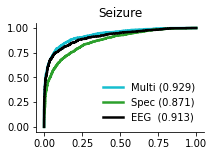

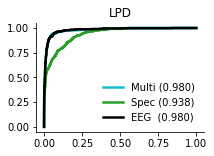

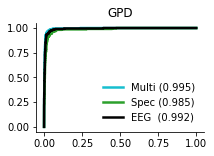

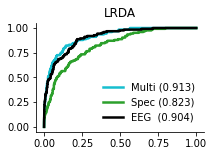

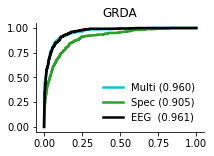

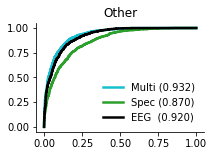

In [7]:
import sklearn
import sklearn.metrics
import seaborn as sns

def get_v(preds, trues, counts):
    inds = (trues.max(axis = 1) >= 0.8) & (counts >= 3)
    plot_preds = preds.copy()[inds]
    plot_trues = trues.copy()[inds]
    temp = np.zeros_like(plot_trues)
    for i in range(len(plot_trues)):
        ind = np.argmax(plot_trues[i])
        temp[i, ind] = 1
    plot_trues = temp
    return plot_preds, plot_trues

aq_multi_preds, aq_multi_trues = get_v(multi_preds, multi_trues, multi_counts)
aq_spec_preds, aq_spec_trues = get_v(spec_preds, spec_trues, spec_counts)
aq_eeg_preds, aq_eeg_trues = get_v(eeg_preds, eeg_trues, eeg_counts)

LABELS = [
    "Seizure", 
    "LPD", 
    "GPD", 
    "LRDA", 
    "GRDA", 
    "Other"
]

colors = [
    "tab:cyan",
    "tab:green",
    "black"
]


for i in range(6):
    fig, ax = plt.subplots(figsize = (3, 2))
    
    multi_fpr, multi_tpr, multi_thresholds = sklearn.metrics.roc_curve(aq_multi_trues[:, i], aq_multi_preds[:, i], drop_intermediate = False)
    spec_fpr, spec_tpr, spec_thresholds = sklearn.metrics.roc_curve(aq_spec_trues[:, i], aq_spec_preds[:, i], drop_intermediate = False)
    eeg_fpr, eeg_tpr, eeg_thresholds = sklearn.metrics.roc_curve(aq_eeg_trues[:, i], aq_eeg_preds[:, i], drop_intermediate = False)

    from scipy.signal import savgol_filter

    multi_auc = sklearn.metrics.auc(multi_fpr, multi_tpr)
    spec_auc = sklearn.metrics.auc(spec_fpr, spec_tpr)
    eeg_auc = sklearn.metrics.auc(eeg_fpr, eeg_tpr)

    ax.plot(multi_fpr, multi_tpr, linewidth = 2.5, label = f"Multi ({multi_auc:.3f})", color = colors[0])
    ax.plot(spec_fpr, spec_tpr, linewidth = 2.5, label = f"Spec ({spec_auc:.3f})", color = colors[1])
    ax.plot(eeg_fpr, eeg_tpr, linewidth = 2.5, label = f"EEG  ({eeg_auc:.3f})", color = colors[2])
    
    sns.despine()

    ax.set_title(f"{LABELS[i]}")
    plt.legend(frameon = False, loc = "lower right")
    plt.savefig(f"./figures/auc_fin_{LABELS[i]}.png", dpi = 1000, facecolor = "white", bbox_inches = "tight")
    plt.show()

In [8]:
# MULTI
# 0.9274314086423302
# 0.027225007502854153

# EEG
# 0.9202746591188117
# 0.0317329868888116

# SPEC
# 0.8731221711423646
# 0.04215273169497218

In [9]:
multi_all = [
    0.6142311861,
    0.5979533057,
    0.6366997472,
    0.6718307978,
    0.6672110851
]
multi_g10 = [
    0.2292070933,
    0.2676588453,
    0.2439503181,
    0.2942628962,
    0.2776142828,
]
multi_l10 = [
    0.7997720077,
    0.7834698504,
    0.8490753440,
    0.8490611674,
    0.8630328392,
]

eeg_all = [
    0.6344272162,
    0.6863796261,
    0.6330883079,
    0.6515986491,
    0.6582062026,
]
eeg_g10 = [
    0.2436203848,
    0.2986495421,
    0.2638789726,
    0.2999130961,
    0.2725058086,
]
eeg_l10 = [
    0.8208534882,
    0.8732484407,
    0.8394974450,
    0.8124048695,
    0.8376179446,
]

spec_all = [
    0.8352394699,
    0.7612577628,
    0.7289497376,
    0.9519495865,
    0.8954161048,
]
spec_g10 = [
    0.4042532962,
    0.4648613726,
    0.3887009793,
    0.4402910883,
    0.4437635702,
]
spec_l10 = [
    1.0531197068,
    0.9130940977,
    0.9095616615,
    1.1795415087,
    1.1047141524,
]

In [10]:
m_all = np.mean(multi_all)
s_all = np.std( multi_all)
m_g10 = np.mean(multi_g10)
s_g10 = np.std( multi_g10)
m_l10 = np.mean(multi_l10)
s_l10 = np.std( multi_l10)
print(f"Multi | All: {m_all:.4f} +- {s_all:.4f} | G10: {m_g10:.4f} +- {s_g10:.4f} | L10: {m_l10:.4f} +- {s_l10:.4f}")

m_all = np.mean(eeg_all)
s_all = np.std( eeg_all)
m_g10 = np.mean(eeg_g10)
s_g10 = np.std( eeg_g10)
m_l10 = np.mean(eeg_l10)
s_l10 = np.std( eeg_l10)
print(f"EEG   | All: {m_all:.4f} +- {s_all:.4f} | G10: {m_g10:.4f} +- {s_g10:.4f} | L10: {m_l10:.4f} +- {s_l10:.4f}")

m_all = np.mean(spec_all)
s_all = np.std( spec_all)
m_g10 = np.mean(spec_g10)
s_g10 = np.std( spec_g10)
m_l10 = np.mean(spec_l10)
s_l10 = np.std( spec_l10)
print(f"spec  | All: {m_all:.4f} +- {s_all:.4f} | G10: {m_g10:.4f} +- {s_g10:.4f} | L10: {m_l10:.4f} +- {s_l10:.4f}")

Multi | All: 0.6376 +- 0.0289 | G10: 0.2625 +- 0.0233 | L10: 0.8289 +- 0.0313
EEG   | All: 0.6527 +- 0.0194 | G10: 0.2757 +- 0.0214 | L10: 0.8367 +- 0.0209
spec  | All: 0.8346 +- 0.0825 | G10: 0.4284 +- 0.0278 | L10: 1.0320 +- 0.1064


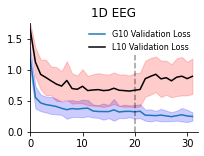

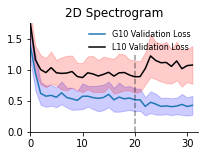

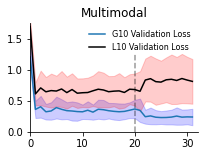

In [11]:
import pandas as pd
import seaborn as sns
import os

def get_metrics(path_s1, path_s2, save_to = None, title = None):
    df_s1_g10 = pd.read_csv(os.path.join(path_s1, "metrics/val-loss_g10.csv"))
    df_s1_l10 = pd.read_csv(os.path.join(path_s1, "metrics/val-loss_l10.csv"))
    df_s2_g10 = pd.read_csv(os.path.join(path_s2, "metrics/val-loss_g10.csv"))
    df_s2_l10 = pd.read_csv(os.path.join(path_s2, "metrics/val-loss_l10.csv"))
    
    epoch = 0
    x = []
    ms_g10 = []
    ss_g10 = []
    ms_l10 = []
    ss_l10 = []
    for a in df_s1_g10.epoch.unique():
        df_g10_epoch = df_s1_g10[df_s1_g10.epoch == a]
        df_l10_epoch = df_s1_l10[df_s1_l10.epoch == a]
        
        ms_g10.append(df_g10_epoch["val/loss_g10"].mean())
        ss_g10.append(df_g10_epoch["val/loss_g10"].std())
        ms_l10.append(df_l10_epoch["val/loss_l10"].mean())
        ss_l10.append(df_l10_epoch["val/loss_l10"].std())
        
        x.append(epoch)        
        epoch += 1
        
    for a in df_s2_g10.epoch.unique():
        df_g10_epoch = df_s2_g10[df_s2_g10.epoch == a]
        df_l10_epoch = df_s2_l10[df_s2_l10.epoch == a]
        
        ms_g10.append(df_g10_epoch["val/loss_g10"].mean())
        ss_g10.append(df_g10_epoch["val/loss_g10"].std())
        ms_l10.append(df_l10_epoch["val/loss_l10"].mean())
        ss_l10.append(df_l10_epoch["val/loss_l10"].std())
        
        x.append(epoch)
        epoch += 1
        
    x = np.array(x)
    ms_g10 = np.array(ms_g10)
    ss_g10 = np.array(ss_g10)
    ms_l10 = np.array(ms_l10)
    ss_l10 = np.array(ss_l10)
    
    fig, ax = plt.subplots(figsize = (3, 2))
    ax.plot(x, ms_g10, linestyle = "-", label = "G10 Validation Loss", color = "tab:blue")
    ax.fill_between(
        x, 
        ms_g10 - ss_g10, 
        ms_g10 + ss_g10, 
        color = "blue", alpha = 0.2
    )
    ax.plot(x, ms_l10, linestyle = "-", label = "L10 Validation Loss", color = "black")
    ax.fill_between(
        x, 
        ms_l10 - ss_l10, 
        ms_l10 + ss_l10, 
        color = "red", alpha = 0.2
    )
    sns.despine()
    plt.vlines([20], ymin = 0, ymax = 1.25, color = "black", alpha = 0.4, linestyle = "--")
    plt.ylim([0, 1.75])
    plt.xlim([0, 32])
    if title is not None:
        plt.title(title)
    plt.legend(frameon = False, fontsize = 8)
    if save_to is not None:
        plt.savefig(save_to, dpi = 1000, facecolor = "white", bbox_inches = "tight")
    plt.show()

eeg_path_s1 = "./logs/eeg_cnn_rnn_att_stage_1_fold_0"
eeg_path_s2 = "./logs/eeg_cnn_rnn_att_stage_2_fold_0"

spec_path_s1 = "./logs/spc_cnn_att_stage_1_fold_0"
spec_path_s2 = "./logs/spc_cnn_att_stage_2_fold_0"

multi_path_s1 = "./logs/multimodal_stage_1_fold_0"
multi_path_s2 = "./logs/multimodal_stage_2_fold_0"

get_metrics(eeg_path_s1, eeg_path_s2, f"./figures/eeg_loss.png", "1D EEG")
get_metrics(spec_path_s1, spec_path_s2, f"./figures/spec_loss.png", "2D Spectrogram")
get_metrics(multi_path_s1, multi_path_s2, f"./figures/multi_loss.png", "Multimodal")